In [0]:
# %pip install uv opencv-python

In [0]:
from huggingface_hub import login
import os

hf_pat = dbutils.secrets.get("justinm-buildathon-secrets", "hf_pat")
os.environ["HF_TOKEN"] = hf_pat
login(token=hf_pat)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [0]:
import torch
import numpy as np
import requests
from PIL import Image
from transformers import Sam3Processor, Sam3Model

/databricks/python/lib/python3.12/site-packages/torch/__init__.py:2064: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  _C._initExtension(_manager_path())
Unexpected internal error when monkey patching `Trainer.train`: cannot import name 'HybridCache' from 'transformers' (/local_disk0/.ephemeral_nfs/envs/pythonEnv-71fa04cf-261c-4cae-8452-3553a59ddbe9/lib/python3.12/site-packages/transformers/__init__.py)


In [0]:
import os
import mlflow
import mlflow.pyfunc
import torch
import numpy as np
import pandas as pd
import requests
from PIL import Image
import base64
from io import BytesIO
from transformers import Sam3Processor, Sam3Model

class SAM3(mlflow.pyfunc.PythonModel):
    """
    MLflow wrapper for Hugging Face Transformers SAM3 models
    """
    
    def load_context(self, context):
        import torch
        import numpy as np
        import requests
        from PIL import Image
        import base64
        from io import BytesIO
        from transformers import Sam3Processor, Sam3Model, logging
        from huggingface_hub import login
        import sys

        if not hasattr(sys.stdout, "isatty"):
            sys.stdout.isatty = lambda: False

        logging.set_verbosity_error()
        logging.disable_progress_bar()

        hf_pat = os.environ["HF_TOKEN"]
        login(token=hf_pat)

        """Load Transformers SAM3 model"""
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = Sam3Model.from_pretrained("facebook/sam3", torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32).to(self.device)
        self.processor = Sam3Processor.from_pretrained("facebook/sam3")

    def segment(self, image: Image.Image, text: str, threshold: float, mask_threshold: float):
        """
        Perform promptable concept segmentation using SAM3.
        Returns format compatible with gr.AnnotatedImage: (image, [(mask, label), ...])
        """
        if image is None:
            return None, "❌ Please upload an image."
        
        if not text.strip():
            return (image, []), "❌ Please enter a text prompt."
        
        try:
            inputs = self.processor(images=image, text=text.strip(), return_tensors="pt").to(self.device)
            
            for key in inputs:
                if inputs[key].dtype == torch.float32:
                    inputs[key] = inputs[key].to(self.model.dtype)
            
            with torch.no_grad():
                outputs = self.model(**inputs)
            
            results = self.processor.post_process_instance_segmentation(
                outputs,
                threshold=threshold,
                mask_threshold=mask_threshold,
                target_sizes=inputs.get("original_sizes").tolist()
            )[0]
            
            n_masks = len(results['masks'])
            if n_masks == 0:
                return (image, []), f"❌ No objects found matching '{text}' (try adjusting thresholds)."
            
            # Format for AnnotatedImage: list of (mask, label) tuples
            # mask should be numpy array with values 0-1 (float) matching image dimensions
            annotations = []
            for i, (mask, score) in enumerate(zip(results['masks'], results['scores'])):
                # Convert binary mask to float numpy array (0-1 range)
                mask_np = mask.cpu().numpy().astype(np.float32)
                label = f"{text} #{i+1} ({score:.2f})"
                annotations.append((mask_np, label))
            
            # scores_text = ", ".join([f"{s:.2f}" for s in results['scores'].cpu().numpy()[:5]])
            # info = f"✅ Found **{n_masks}** objects matching **'{text}'**\nConfidence scores: {scores_text}{'...' if n_masks > 5 else ''}"
            
            # Return tuple: (base_image, list_of_annotations)
            return [mask for mask, _ in annotations]
            # return annotations, info
            # return (image, annotations), info
        
        except Exception as e:
            return ([]), f"❌ Error during segmentation: {str(e)}"
            # return (image, []), f"❌ Error during segmentation: {str(e)}"
                    
    def convert_image(self, image_path):
        if image_path.startswith("http"):
            image = Image.open(requests.get(image_path, stream=True).raw).convert("RGB")
        elif image_path.startswith('/'):
            image = Image.open(image_path).convert("RGB")
        elif image_path.startswith('data:image'):
            header, b64_string = image_path.split(",", 1)
            image_bytes = base64.b64decode(b64_string)
            image = Image.open(BytesIO(image_bytes))
        elif isinstance(image_path, str):
            image_bytes = base64.b64decode(image_path)
            image = Image.open(BytesIO(image_bytes))
        elif isinstance(image_path, bytes):
            image = Image.open(BytesIO(image_bytes))
        else:
            return "❌ Unsupported image type"
        return image

    def predict(self, context, model_input, params=None):
        if isinstance(model_input, pd.DataFrame):
            # print("pandas")
            image_path = model_input['image_path'].tolist()[0]
            prompt = model_input["prompt"].tolist()[0]
            threshold = model_input["threshold"].tolist()[0]
            mask_threshold = model_input["mask_threshold"].tolist()[0]
        else:
            # print("dict")
            image_path = model_input["image_path"]
            prompt = model_input["prompt"]
            threshold = model_input["threshold"]
            mask_threshold = model_input["mask_threshold"]

        image = self.convert_image(image_path)
        if image == "❌ Unsupported image type":
            return [image]
        
        return self.segment(image, prompt, threshold, mask_threshold)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-71fa04cf-261c-4cae-8452-3553a59ddbe9/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [0]:
sam = SAM3()

class ContextObject():
    def __init__(self, artifacts):
        self.artifacts = None

artifacts = None
sam_context = ContextObject(artifacts)

sam.load_context(context = sam_context)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [0]:
import timeit
import base64

def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        base64_string = base64.b64encode(image_file.read()).decode('utf-8')
    return base64_string

# Example usage
image_path = "/Volumes/pubsec_video_processing/cv/auto_segment/images/bruno.png"
image_path = image_to_base64(image_path)
prompt = "weimaraner"
model_input = {
    "image_path": image_path,
    "prompt": prompt,
    "threshold": 0.5,
    "mask_threshold": 0.5
}

starting_time = timeit.default_timer()
response = sam.predict(
    context = None,
    model_input = model_input,
    params = None
)
print(f"Inference time: {round((timeit.default_timer() - starting_time)*1000)} ms")
print(response)


# base64_string = image_to_base64(image_path)
# # print(base64_string)

# starting_time = timeit.default_timer()
# model_input = {
#   "image": base64_string
# }
# response = yolo.predict(
#   context = None,
#   model_input = model_input,
#   params = None
# )
# print(f"Inference time: {round((timeit.default_timer() - starting_time)*1000)} ms")
# print(response)

Inference time: 241 ms
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]


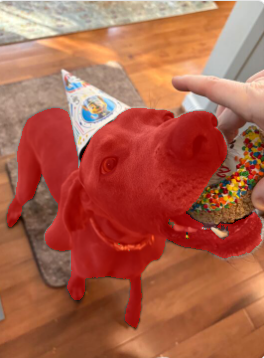

In [0]:
from PIL import Image

def convert_image(image_path):
    if image_path.startswith("http"):
        image = Image.open(requests.get(image_path, stream=True).raw).convert("RGB")
    elif image_path.startswith('/'):
        image = Image.open(image_path).convert("RGB")
    elif image_path.startswith('data:image'):
        header, b64_string = image_path.split(",", 1)
        image_bytes = base64.b64decode(b64_string)
        image = Image.open(BytesIO(image_bytes))
    elif isinstance(image_path, str):
        image_bytes = base64.b64decode(image_path)
        image = Image.open(BytesIO(image_bytes))
    elif isinstance(image_path, bytes):
        image = Image.open(BytesIO(image_bytes))
    else:
        return "❌ Unsupported image type"
    return image

# # Unpack your data structure
# img = response[0][0]
# mask_list = response[0][1]
# message = response[1]
# # ((img, mask_list), message) = segmented_image[0]  # whatever your variable is called
# mask, label = mask_list[0]       # first mask

# Unpack your data structure
image_path = model_input['image_path']
# if image_path.startswith("http"):
#     img = Image.open(requests.get(image_path, stream=True).raw).convert("RGB")
# else:
#     img = Image.open(image_path).convert("RGB")
img = convert_image(image_path)

mask_list = response[0]
message = response[1]
# ((img, mask_list), message) = segmented_image[0]  # whatever your variable is called
mask, label = mask_list[0]       # first mask

# Get mask in 0–255 range
mask_uint8 = (mask * 255).astype("uint8")

# Convert mask to RGBA (red overlay)
overlay = Image.fromarray(mask_uint8, mode="L").convert("RGBA")
overlay_data = overlay.load()

# Color the mask red with alpha proportional to mask value
for y in range(overlay.height):
    for x in range(overlay.width):
        a = overlay_data[x, y][0]  # original grayscale value = alpha
        overlay_data[x, y] = (255, 0, 0, int(a/2))  # red with transparency

# Composite
result = Image.alpha_composite(img.convert("RGBA"), overlay)

result

In [0]:
from mlflow.tracking import MlflowClient
from mlflow.models import infer_signature

# specify the location the model will be saved/registered in Unity Catalog
catalog = "pubsec_video_processing"
schema = "cv"
model_name = "transformers-sam3"
model_full_name = f"{catalog}.{schema}.{model_name}"
mlflow.set_registry_uri("databricks-uc")

signature = infer_signature(model_input=model_input, model_output=response)

# Define conda environment with dependencies
conda_env = {
    'channels': ['conda-forge', 'defaults'],
    'dependencies': [
        'python=3.12.3',
        'pip',
        {
            'pip': [
                'mlflow>=2.10.0',
                'torch>=2.0.0',
                'git+https://github.com/huggingface/transformers.git',
                'Pillow',
                'torchvision',
                "cloudpickle==3.0.0",
                # 'pillow>=9.0.0',
                'numpy>=1.23.0',
                'pandas>=1.5.0',
                'accelerate>=0.20.0'
            ]
        }
    ],
    'name': 'sam3_tracker_env'
}

with mlflow.start_run() as run:
    mlflow.pyfunc.log_model(
        artifact_path="model",
        python_model=SAM3(),
        signature=signature,
        conda_env=conda_env,
        # extra_pip_requirements=[
        #   "torch",
        #   "git+https://github.com/huggingface/transformers.git",
        #   "Pillow"
        # ]
    )
    
    run_id = run.info.run_id
    print(f"Model registered! URI: runs:/{run_id}/model")

2026/01/21 16:43:52 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2026/01/21 16:43:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://fe-vm-industry-solutions-buildathon.cloud.databricks.com/ml/experiments/4273953546972828/models/m-895a7872ccac488c8be73ddb3ff85e37?o=237438879023004
/local_disk0/.ephemeral_nfs/envs/pythonEnv-71fa04cf-261c-4cae-8452-3553a59ddbe9/lib/python3.12/site-packages/mlflow/pyfunc/__init__.py:3288: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter. See https://mlflow.org/docs/latest/model/signatures.html#model-input-example for more details about the benefits of using input_example.
  color_warning(
2026/01/21 16:43:55 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2026/01/21 16:43:55 INFO mlflow.system_me

Model registered! URI: runs:/ddf7c0b22f8443a6a4872b0625efb986/model


In [0]:
model_uri = f"runs:/{run_id}/model"

loaded_model = mlflow.pyfunc.load_model(model_uri)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [0]:
import timeit

starting_time = timeit.default_timer()
model_output = loaded_model.predict(model_input)
print(f"Inference time: {round((timeit.default_timer() - starting_time)*1000)}ms")
print(model_output)

Inference time: 248ms
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]


In [0]:
input = {
    'model_input': [model_input]
}

input_df = pd.DataFrame([model_input])
# print(input_df)

input = model_input
# print(input)

result = mlflow.models.predict(
    model_uri = model_uri,
    # input_data = input_df,
    input_data = input_df,
    content_type="json",
    install_mlflow=False,
    env_manager='uv'
)

2026/01/21 16:45:01 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


2026/01/21 16:45:03 INFO mlflow.utils.virtualenv: Creating a new environment in /tmp/virtualenv_envs_e3b89dd0/mlflow-03d4f704a24da1e3ab37de06a80511959ca1a2be with python version 3.12.3 using uv
Using CPython 3.12.3 interpreter at: /usr/bin/python3.12
Creating virtual environment at: /tmp/virtualenv_envs_e3b89dd0/mlflow-03d4f704a24da1e3ab37de06a80511959ca1a2be
Activate with: source /tmp/virtualenv_envs_e3b89dd0/mlflow-03d4f704a24da1e3ab37de06a80511959ca1a2be/bin/activate
2026/01/21 16:45:04 INFO mlflow.utils.virtualenv: Installing dependencies
Using Python 3.12.3 environment at: /tmp/virtualenv_envs_e3b89dd0/mlflow-03d4f704a24da1e3ab37de06a80511959ca1a2be
Resolved 3 packages in 36ms
Prepared 3 packages in 130ms
Installed 3 packages in 32ms
 + pip==25.0.1
 + setuptools==74.0.0
 + wheel==0.45.1
Using Python 3.12.3 environment at: /tmp/virtualenv_envs_e3b89dd0/mlflow-03d4f704a24da1e3ab37de06a80511959ca1a2be
   Updating https://github.com/huggingface/transformers.git (HEAD)
    Updated http

{"predictions": [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [0]:
# register the model using the "run" from above.
mlflow.register_model(model_uri=f"runs:/{run_id}/model", name=model_full_name)

Registered model 'pubsec_video_processing.cv.transformers-sam3' already exists. Creating a new version of this model...
2026/01/21 16:47:13 WARNING mlflow.tracking._model_registry.fluent: Run with id ddf7c0b22f8443a6a4872b0625efb986 has no artifacts at artifact path 'model', registering model based on models:/m-895a7872ccac488c8be73ddb3ff85e37 instead


Uploading artifacts:   0%|          | 0/10 [00:00<?, ?it/s]

🔗 Created version '2' of model 'pubsec_video_processing.cv.transformers-sam3': https://fe-vm-industry-solutions-buildathon.cloud.databricks.com/explore/data/models/pubsec_video_processing/cv/transformers-sam3/version/2?o=237438879023004


<ModelVersion: aliases=[], creation_timestamp=1769014035204, current_stage=None, deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1769014042647, metrics=[], model_id='m-895a7872ccac488c8be73ddb3ff85e37', name='pubsec_video_processing.cv.transformers-sam3', params=[], run_id='ddf7c0b22f8443a6a4872b0625efb986', run_link=None, source='models:/m-895a7872ccac488c8be73ddb3ff85e37', status='READY', status_message='', tags={}, user_id='justin.monaldo@databricks.com', version='2'>

In [0]:
import datetime
import mlflow
from mlflow.tracking import MlflowClient
from databricks.sdk import WorkspaceClient

from databricks.sdk.service.serving import (
    EndpointCoreConfigInput,
    ServedModelInput,
    ServedModelInputWorkloadSize,
    ServedModelInputWorkloadType,
    ServingEndpointDetailed,
)

catalog = "pubsec_video_processing"
schema = "cv"
model_name = "transformers-sam3"
model_full_name = f"{catalog}.{schema}.{model_name}"
mlflow.set_registry_uri("databricks-uc")

# name the endpoint
endpoint_name = model_full_name.replace(".","_") + "_endpoint"
using_gpu = True

# specify Unity Catalog as the model registry
mlflow_client = MlflowClient(registry_uri="databricks-uc")

# Use the MlflowClient to get a list of all versions for the registered model in Unity Catalog
all_versions = mlflow_client.search_model_versions(f"name='{model_full_name}'")
# then sort the list of versions by version number and get the latest version
latest_version = max([int(v.version) for v in all_versions])
# finally, use the MlflowClient to get the latest version of the registered model in Unity Catalog
latest_model = mlflow_client.get_model_version(model_full_name, str(latest_version))

# use databricks-sdk to launch the model serving endpoint
wc = WorkspaceClient()
served_models =[ServedModelInput(model_name=model_full_name, scale_to_zero_enabled=True,
                                environment_vars={"HF_TOKEN":"{{secrets/justinm-buildathon-secrets/hf_pat}}"},
                                model_version=latest_model.version,
                                workload_size=ServedModelInputWorkloadSize.SMALL, # compute workload size for necessary concurrency 
                                workload_type=ServedModelInputWorkloadType.GPU_SMALL if using_gpu else ServedModelInputWorkloadType.CPU, # CPU or GPU workload type
                                )]
                                # scale_to_zero_enabled=True)]

try:
    print(f'Creating endpoint {endpoint_name} with latest version...')
    wc.serving_endpoints.create_and_wait(endpoint_name, config=EndpointCoreConfigInput(served_models=served_models), timeout=datetime.timedelta(seconds=3600))
    print(f'Endpoint created: {endpoint_name}')
except Exception as e:
    if 'already exists' in str(e):
        # print(f'Endpoint exists, skipping...')
        print(f'Endpoint exists, updating with latest model version...')
        wc.serving_endpoints.update_config_and_wait(endpoint_name, served_models=served_models, timeout=datetime.timedelta(seconds=3600))
    else: 
        raise e

Creating endpoint pubsec_video_processing_cv_transformers-sam3_endpoint with latest version...
Endpoint exists, updating with latest model version...


In [0]:
import os
import requests
import json
import timeit
import pandas as pd

# DATABRICKS_TOKEN = dbutils.secrets.get(scope="your-secrets", key="your_pat")
DATABRICKS_TOKEN = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()
DATABRICKS_HOST = dbutils.notebook.entry_point.getDbutils().notebook().getContext().browserHostName().toString()[5:-1]
try:
    endpoint_name = model_full_name.replace(".","_") + "_endpoint"
except:
    endpoint_name = "pubsec_video_processing_cv_transformers-sam3_endpoint"

image_path = "/Volumes/pubsec_video_processing/cv/images/bruno.png"
image_path = "https://www.prodograw.com/wp-content/uploads/2025/09/Weimaraner-2-1.jpg"
prompt = "weimaraner"
model_input = {
    "image_path": image_path,
    "prompt": prompt,
    "threshold": 0.5,
    "mask_threshold": 0.5
}

input = {
    'inputs': [model_input]
}

headers = {"Context-Type": "text/json", "Authorization": f"Bearer {DATABRICKS_TOKEN}"}
url = f'https://{DATABRICKS_HOST}/serving-endpoints/{endpoint_name}/invocations'

print(url)
starting_time = timeit.default_timer()
response = requests.post(
    url=url, json=input, headers=headers
)
print(f"\nInference time, end 2 end :{round((timeit.default_timer() - starting_time)*1000)}ms\n")

print(json.dumps(response.json()))  

https://fe-vm-industry-solutions-buildathon.cloud.databricks.com/serving-endpoints/pubsec_video_processing_cv_transformers-sam3_endpoint/invocations

Inference time, end 2 end :2205ms



{"predictions": [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [0]:
from PIL import Image

res = response.json()['predictions']

# Unpack your data structure
image_path = model_input['image_path']
if image_path.startswith("http"):
    img = Image.open(requests.get(image_path, stream=True).raw).convert("RGB")
else:
    img = Image.open(image_path).convert("RGB")
mask_list = res[0]
message = res[1]
# ((img, mask_list), message) = segmented_image[0]  # whatever your variable is called
mask, label = mask_list[0]       # first mask

# Get mask in 0–255 range
import numpy as np
mask_uint8 = (np.array(mask) * 255).astype("uint8")


# Convert mask to RGBA (red overlay)
overlay = Image.fromarray(mask_uint8, mode="L").convert("RGBA")
overlay_data = overlay.load()

# Color the mask red with alpha proportional to mask value
for y in range(overlay.height):
    for x in range(overlay.width):
        a = overlay_data[x, y][0]  # original grayscale value = alpha
        overlay_data[x, y] = (255, 0, 0, int(a/2))  # red with transparency

# Composite
result = Image.alpha_composite(img.convert("RGBA"), overlay)

result